# Определение перспективного тарифа для телеком-компании

Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

В нашем распоряжении выборка данных из 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

В ходе исследования проверим две гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

## Изучение данных из файла

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [23]:
calls = pd.read_csv('/datasets/calls.csv')
display(calls.head())
calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [24]:
internet = pd.read_csv('/datasets/internet.csv')
display(internet.head())
internet.info()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [25]:
messages = pd.read_csv('/datasets/messages.csv')
display(messages.head())
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [26]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [27]:
users = pd.read_csv('/datasets/users.csv')
display(users.head())
users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


### Вывод

Все данные разделены на пять таблиц, в которых описывается информация о клиенте (возраст, город проживания, ФИО, тариф, дата подключения) и как он пользовался услугами Компании (информация о звонках, сообщениях, интернет-сессиях). 

Пропущенные значения обнаружены только в столбце `churn_date` таблицы `users`. Согласно документации пропущенное значение свидетельствует о действующем тарифе на момент выгрузки данных. 

## Предобработка данных

Согласно документации, длительность звонков и потребляемый трафик округляется в большую сторону с секунд до минут и с Мб до Гб.

Приведём фактические значения к округлённым для удобства расчёта, а также изменим тип данных в столбцах с датой.

In [28]:
calls['call_date'] = calls['call_date'].astype('datetime64')
calls['duration'] = calls['duration'].apply(np.ceil).astype(int)

In [29]:
internet['session_date'] = internet['session_date'].astype('datetime64')

In [30]:
messages['message_date'] = messages['message_date'].astype('datetime64')

In [31]:
tariffs = tariffs.rename(columns={'tariff_name': 'tariff', 'mb_per_month_included': 'gb_per_month_included'})
tariffs['gb_per_month_included'] = tariffs['gb_per_month_included'] / 1024
tariffs['gb_per_month_included'] = tariffs['gb_per_month_included'].astype(int)

### Вывод

Данные в таблицах подготовлены для дальнейших группировок и расчётов.

## Расчёты и группировка результатов 

Сгруппируем по каждому клиенту и месяцу количество звонков и их суммарную длительность.

In [32]:
calls['month'] = calls['call_date'].dt.month
calls_grouped = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum'])
calls_grouped.columns = ['count_call', 'sum_call']
display(calls_grouped)

count_call  sum_call
user_id month                      
1000    5              22       159
        6              43       172
        7              47       340
        8              52       408
        9              58       466
...                   ...       ...
1498    10             41       247
1499    9               9        70
        10             68       449
        11             74       612
        12             69       492

[3174 rows x 2 columns]

Такая же группировка с сообщениями.

In [33]:
messages['month'] = messages['message_date'].dt.month
messages_grouped = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_grouped.columns = ['count_message']
display(messages_grouped)

count_message
user_id month               
1000    5                 22
        6                 60
        7                 75
        8                 81
        9                 57
...                      ...
1498    10                42
1499    9                 11
        10                48
        11                59
        12                66

[2717 rows x 1 columns]

Группировка с использованным трафиком.

In [34]:
internet['month'] = internet['session_date'].dt.month
internet_grouped = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_grouped['mb_used'] = internet_grouped['mb_used'] / 1024
internet_grouped['mb_used'] = internet_grouped['mb_used'].apply(np.ceil).astype(int)
internet_grouped = internet_grouped.rename(columns={'mb_used': 'gb_used'})
display(internet_grouped)

gb_used
user_id month         
1000    5            3
        6           23
        7           14
        8           14
        9           15
...                ...
1498    10          21
1499    9            2
        10          18
        11          18
        12          13

[3203 rows x 1 columns]

Объединяем информацию по пользователям по звонкам, сообщениям и интернету.

In [35]:
total_df = calls_grouped.join([messages_grouped, internet_grouped], how='outer')
display(total_df)

count_call  sum_call  count_message  gb_used
user_id month                                              
1000    5            22.0     159.0           22.0      3.0
        6            43.0     172.0           60.0     23.0
        7            47.0     340.0           75.0     14.0
        8            52.0     408.0           81.0     14.0
        9            58.0     466.0           57.0     15.0
...                   ...       ...            ...      ...
1498    10           41.0     247.0           42.0     21.0
1499    9             9.0      70.0           11.0      2.0
        10           68.0     449.0           48.0     18.0
        11           74.0     612.0           59.0     18.0
        12           69.0     492.0           66.0     13.0

[3214 rows x 4 columns]

Добавляем к объединённой таблице личную информацию по пользователям.

In [36]:
total_df = total_df.reset_index()
total_df = total_df.merge(users, on='user_id', how='outer')
display(total_df)

,user_id,month,count_call,sum_call,count_message,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5.0,22.0,159.0,22.0,3.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6.0,43.0,172.0,60.0,23.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7.0,47.0,340.0,75.0,14.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8.0,52.0,408.0,81.0,14.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9.0,58.0,466.0,57.0,15.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1499,10.0,68.0,449.0,48.0,18.0,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart
3212,1499,11.0,74.0,612.0,59.0,18.0,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart
3213,1499,12.0,69.0,492.0,66.0,13.0,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart
3214,1128,NaN,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra


Для удобства расчёта выручки с каждого пользователя добавляем таблицу с информацией по тарифам.

In [37]:
total_df = total_df.merge(tariffs, on='tariff')
display(total_df)

,user_id,month,count_call,sum_call,count_message,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,22.0,159.0,22.0,3.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1
1,1000,6.0,43.0,172.0,60.0,23.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1
2,1000,7.0,47.0,340.0,75.0,14.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1
3,1000,8.0,52.0,408.0,81.0,14.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1
4,1000,9.0,58.0,466.0,57.0,15.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1499,9.0,9.0,70.0,11.0,2.0,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15,500,550,200,3,3
3212,1499,10.0,68.0,449.0,48.0,18.0,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15,500,550,200,3,3
3213,1499,11.0,74.0,612.0,59.0,18.0,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15,500,550,200,3,3
3214,1499,12.0,69.0,492.0,66.0,13.0,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15,500,550,200,3,3


Производим помесячный расчёт выручки по каждому пользователю и добавляем соответствующий столбец в таблицу.

In [38]:
def revenue_for_month(row):
    calls = (row['sum_call'] - row['minutes_included']) * row['rub_per_minute']
    messages = (row['count_message'] - row['messages_included']) * row['rub_per_message']
    gb = (row['gb_used'] - row['gb_per_month_included']) * row['rub_per_gb']
    revenue = 0
    for x in [calls, messages, gb]:
        if x > 0:
            revenue += x
    return revenue + row['rub_monthly_fee']
   
total_df['revenue_for_month'] = total_df.apply(revenue_for_month, axis=1)  
total_df

,user_id,month,count_call,sum_call,count_message,gb_used,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue_for_month
0,1000,5.0,22.0,159.0,22.0,3.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30,3000,1950,150,1,1,1950.0
1,1000,6.0,43.0,172.0,60.0,23.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30,3000,1950,150,1,1,1950.0
2,1000,7.0,47.0,340.0,75.0,14.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30,3000,1950,150,1,1,1950.0
3,1000,8.0,52.0,408.0,81.0,14.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30,3000,1950,150,1,1,1950.0
4,1000,9.0,58.0,466.0,57.0,15.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30,3000,1950,150,1,1,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1499,9.0,9.0,70.0,11.0,2.0,35,NaN,Пермь,Гектор,...,2018-09-27,smart,50,15,500,550,200,3,3,550.0
3212,1499,10.0,68.0,449.0,48.0,18.0,35,NaN,Пермь,Гектор,...,2018-09-27,smart,50,15,500,550,200,3,3,1150.0
3213,1499,11.0,74.0,612.0,59.0,18.0,35,NaN,Пермь,Гектор,...,2018-09-27,smart,50,15,500,550,200,3,3,1513.0
3214,1499,12.0,69.0,492.0,66.0,13.0,35,NaN,Пермь,Гектор,...,2018-09-27,smart,50,15,500,550,200,3,3,598.0


### Вывод

Провели необходимые расчёты и объединение данных в одну общую таблицу.

Можно проводить анализ получившихся данных и проверку гипотез.

## Исследовательский анализ данных

Сравним "поведение" клиентов двух тарифов.

In [39]:
ultra = total_df.query('tariff == "ultra"')
smart = total_df.query('tariff == "smart"')

for column in ['sum_call', 'count_message', 'gb_used', 'revenue_for_month']:
    print(f'{column}, среднее: {ultra[column].mean()}')
    print(f'дисперсия: {np.var(ultra[column], ddof=1)}')
    print(f'стандартное отклонение: {np.std(ultra[column], ddof=1)}')
    print()

sum_call, среднее: 545.4511041009464
дисперсия: 94203.41839614809
стандартное отклонение: 306.9257538821858

count_message, среднее: 61.161006289308176
дисперсия: 2109.6591828651995
стандартное отклонение: 45.93102636416042

gb_used, среднее: 19.694358974358973
дисперсия: 94.14673405991681
стандартное отклонение: 9.70292399536948

revenue_for_month, среднее: 2070.030425963489
дисперсия: 141387.7148093615
стандартное отклонение: 376.0155778812382



In [40]:
for column in ['sum_call', 'count_message', 'gb_used', 'revenue_for_month']:
    print(f'{column}, среднее: {smart[column].mean()}')
    print(f'дисперсия: {np.var(smart[column], ddof=1)}')
    print(f'стандартное отклонение: {np.std(smart[column], ddof=1)}')
    print()

sum_call, среднее: 419.0629779577148
дисперсия: 35844.1895513438
стандартное отклонение: 189.3256177894154

count_message, среднее: 38.71644120707596
дисперсия: 717.5942011753547
стандартное отклонение: 26.787948804926344

gb_used, среднее: 16.33617594254937
дисперсия: 32.92375582354312
стандартное отклонение: 5.737922605224221

revenue_for_month, среднее: 1289.6417040358745
дисперсия: 669730.763894807
стандартное отклонение: 818.370798534996



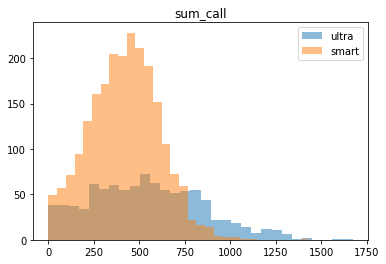

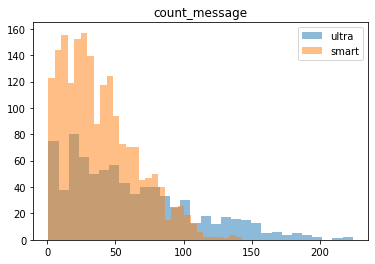

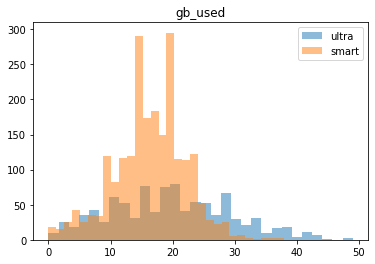

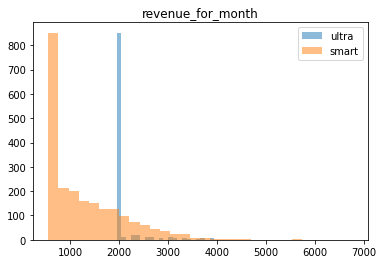

In [41]:
ultra = total_df.query('tariff == "ultra"')
smart = total_df.query('tariff == "smart"')

for column in ['sum_call', 'count_message', 'gb_used', 'revenue_for_month']:
    plt.hist(ultra[column], bins=30, alpha = 0.5, label='ultra')
    plt.hist(smart[column], bins=30, alpha = 0.5, label='smart')
    plt.legend(loc='upper right')
    plt.title(column)
    plt.show()

In [42]:
print(len(ultra['user_id'].unique()))
len(smart['user_id'].unique())

149


351

### Вывод
У тарифа "Смарт" дешевле абонентская плата и пользователей у него больше, чем у тарифа "Ультра" в 2,3 раза. Поэтому на гистограммах тариф "Ультра" меньше выделяется, но можно определить характерные черты, различия и сходства тарифов.

- количество использованных минут в тарифе "Смарт" нормально распределено, среднее в районе 500 минут; в тарифе "Ультра" есть пик на уровне чуть больше 500 минут, но разброс не такой большой и основная масса использует от 250 до 870 минут;
- гистограммы сообщений в обоих тарифах скошены вправо. В тарифе "Смарт" используют, в основном, до 50 сообщений, в тарифе "Ультра" - до 100;
- в тарифе "Смарт" основная масса клиентов использует от 35 до 60 Гб, в тарифе "Ультра" нет таких явных различий -  равномерное распределение с пиками около 40 и 50 Гб;
- большая часть пользователей обоих тарифов укладываются в лимиты и оплачивают только абонентскую плату. 
- среднее использованное количество минут и сообщений у клиентов тарифа "Ультра" больше, чем у клиентов тарифа "Смарт" (545 минут и 61 сообщение против 419 минут и 39 сообщений). Это объяснимо - в тарифе "Ультра" заложены большие лимиты и пользователи, его выбирающие, изначально нацелены на большее пользование услугами связи. Использованный траффик не сильно различается между тарифами (20 Гб - "Ультра" против 16 Гб - "Смарт").


## Проверка гипотез

### Сравнение выручки клиентов двух тарифов

Согласно первой гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Нулевая гипотеза будет звучать так: средняя выручка пользователей тарифов «Ультра» и «Смарт» равны.

Расчёты средних значений выручки показали, что выручка тарифа "Ультра" больше. Альтернативную гипотезу сформулируем так: средняя выручка пользователей тарифа «Ультра» выше, чем пользователей тарифа "Смарт".

In [43]:
ultra_mean = 2070
alpha = .05

results = st.ttest_1samp(smart['revenue_for_month'], ultra_mean)
print('p-значение:', results.pvalue / 2)

if (results.pvalue / 2 < alpha) and (smart['revenue_for_month'].mean() < ultra_mean):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу") 
                               

p-значение: 9.1248456e-316
Отвергаем нулевую гипотезу


Полученное значение p-value говорит о том, что вероятность получить такое или большее различие случайно чрезвычайно низкая. Проведённая проверка показала, что можно отвергнуть гипотезу о равенстве выручек пользователей двух тарифов и при этом верна гипотеза о том, что выручка клиентов тарифа "Ультра" выше выручки пользователей тарифа "Смарт".  

### Сравнение выручки пользователей из Москвы и пользователей из других регионов

Вторая гипотеза говорит о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Нулевая гипотеза: выручка пользователей из Москвы и других регионов равны.

Альтернативная гипотеза: выручка пользователей из Москвы и других регионов различаются.

In [44]:
msc = total_df.query('city == "Москва"')
regions = total_df.query('city != "Москва"')

In [45]:
alpha = .05
results = st.ttest_ind(msc['revenue_for_month'], regions['revenue_for_month'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5400751614511182
Не получилось отвергнуть нулевую гипотезу


При проверке данной гипотезы выявили, что вероятность получить такое или большее различие случайно почти 54%. Это слишком большая вероятность, чтобы делать вывод о значимом различии между выручками пользователей из Москвы и других регионов.

## Общий вывод

В процессе выполнения работы было сделано следующее:

- ознакомились с полученными данными на предмет соответствия, стоящей перед нами задачей;
- подготовили данные для анализа: округлили цифры в соответствии с документацией, объединили в общую таблицу, рассчитали выручку по каждому пользователю;
- по выборке описали поведение клиентов оператора;
- проверили гипотезы: различия выручки пользователей тарифов «Ультра» и «Смарт», различия выручки пользователей из Москвы и пользователей из других регионов.

В ходе изучения данных установили:

- пользователей тарифа "Смарт" больше примерно в 2,3 раза;
- пользователи тарифа "Ультра", в среднем, больше разговаривают по телефону и посылают сообщений, чем пользователи тарифа "Смарт" (545 минут и 61 сообщение против 419 минут и 39 сообщений), использование трафика чуть больше в пользу клиентов тарифа "Ультра" (20 Гб против 16 Гб);
- отвергнули гипотезу о равенстве выручек пользователей двух тарифов и приняли гипотезу о том, что выручка клиентов тарифа "Ультра" выше выручки пользователей тарифа "Смарт" (стоит это учесть при корректировке рекламного бюджета);
- сравнение выручки пользователей из Москвы и пользователей из других регионов показало, что верна гипотеза о равенстве выручек таких пользователей. 
    
